In [3]:
from keras.layers import LSTM
from keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#standardize the data
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [4]:
def load_data(path):
    df = pd.read_csv(path)
    print(df.info())
    #convert the date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    print(df.head())
    print(df.info())
    return df


In [5]:
path='/Users/rianrachmanto/pypro/data/esp_new.csv'
df = load_data(path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202978 entries, 0 to 202977
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Well             202978 non-null  object 
 1   Date             202978 non-null  object 
 2   Hours_Online     91217 non-null   float64
 3   Freq             79585 non-null   float64
 4   Ampere           83274 non-null   float64
 5   Volt             76026 non-null   float64
 6   Press_Discharge  57558 non-null   float64
 7   TM               39661 non-null   float64
 8   Vibration        36035 non-null   float64
 9   Gross_Rate       85310 non-null   float64
dtypes: float64(8), object(2)
memory usage: 15.5+ MB
None
  Well       Date  Hours_Online  Freq  Ampere   Volt  Press_Discharge     TM  \
0  BC1 2011-09-02          24.0   NaN    19.2  343.2              NaN  175.0   
1  BC1 2011-09-03          24.0   NaN    18.3  339.6              NaN  177.4   
2  BC1 2011-09-04          

In [6]:
def select_freq(df, well_name):
    # Filter the DataFrame for the given well name
    df_freq = df[df['Well'] == well_name][['Well', 'Date', 'Volt']]
    print(df_freq.head())
    return df_freq


In [7]:
df_freq = select_freq(df, 'BS3')

     Well       Date   Volt
9277  BS3 2011-09-01    NaN
9278  BS3 2011-09-02  430.0
9279  BS3 2011-09-03  428.4
9280  BS3 2011-09-04  421.0
9281  BS3 2011-09-05  428.0


In [8]:
def train_test (df_freq):
    #split based on length of the data with 80% training and 20% testing
    train_size = int(len(df_freq) * 0.8)
    test_size = len(df_freq) - train_size
    train, test = df_freq.iloc[0:train_size], df_freq.iloc[train_size:len(df_freq)]
    print(train.shape, test.shape)
    print(train.head())
    return train, test

In [9]:
train, test = train_test(df_freq)

(3711, 3) (928, 3)
     Well       Date   Volt
9277  BS3 2011-09-01    NaN
9278  BS3 2011-09-02  430.0
9279  BS3 2011-09-03  428.4
9280  BS3 2011-09-04  421.0
9281  BS3 2011-09-05  428.0


In [10]:
def clean_train(train):
    #drop all the missing values
    train = train.dropna()
    print(train.shape)
    print(train.head())
    return train

def clean_test(test):
    #drop all the missing values
    test = test.dropna()
    print(test.shape)
    print(test.head())
    return test

In [11]:
train = clean_train(train)
test = clean_test(test)

(1176, 3)
     Well       Date   Volt
9278  BS3 2011-09-02  430.0
9279  BS3 2011-09-03  428.4
9280  BS3 2011-09-04  421.0
9281  BS3 2011-09-05  428.0
9282  BS3 2011-09-06  420.0
(571, 3)
      Well       Date   Volt
13135  BS3 2022-03-25  329.0
13136  BS3 2022-03-26  343.0
13142  BS3 2022-04-01  401.0
13143  BS3 2022-04-02  401.0
13144  BS3 2022-04-03  400.0


In [12]:
#plot the data as time series
def plot_data(train):
    plt.figure(figsize=(12,6))
    plt.plot(train['Date'], train['Volt'])
    plt.title('Frequency vs Time')
    plt.ylabel('Frequency')
    plt.xlabel('Date')
    plt.show()

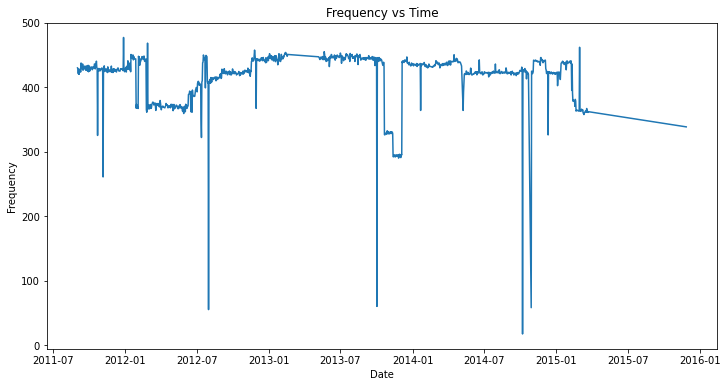

In [13]:
plot_data(train)

In [14]:
#preprocess train data to standardize the data
def preprocess_train(train, test):
    # Create copies of the input DataFrames to avoid modifying original data
    scaled_train = train.copy()
    scaled_test = test.copy()

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on the training data
    scaler = scaler.fit(train[['Volt']])

    # Transform the 'Freq' column for both training and testing data
    scaled_train['Volt'] = scaler.transform(train[['Volt']])
    scaled_test['Volt'] = scaler.transform(test[['Volt']])

    print(scaled_train.head())
    return scaled_train, scaled_test, scaler


In [15]:
scaled_train,scaled_test,scaler = preprocess_train(train,test)

     Well       Date      Volt
9278  BS3 2011-09-02  0.315679
9279  BS3 2011-09-03  0.275282
9280  BS3 2011-09-04  0.088447
9281  BS3 2011-09-05  0.265183
9282  BS3 2011-09-06  0.063199


In [16]:
import numpy as np

def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps):
        # Define the end of the sequence
        end_ix = i + n_steps
        # Gather input and output parts of the pattern
        seq_x = data[i:end_ix]
        X.append(seq_x)
    return np.array(X)


In [17]:
# Assuming you have already called preprocess_train and obtained scaled_train and scaled_test
n_steps = 24
# Convert DataFrame to numpy array for easier manipulation
train_freq = scaled_train['Volt'].values
test_freq = scaled_test['Volt'].values

# Create sequences
X_train = create_sequences(train_freq, n_steps)
X_test = create_sequences(test_freq, n_steps)

# Print the shapes to understand the dimensions
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (1152, 24)
Test data shape: (547, 24)


In [18]:
# Reshape the data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Reshaped training data shape:", X_train.shape)
print("Reshaped test data shape:", X_test.shape)


Reshaped training data shape: (1152, 24, 1)
Reshaped test data shape: (547, 24, 1)


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

def build_autoencoder(time_steps, n_features):
    with tf.device('/device:GPU:0'):

        # Encoder
        encoder = Sequential()
        encoder.add(LSTM(32, activation='relu', input_shape=(time_steps, n_features), return_sequences=False))
        encoder.add(RepeatVector(time_steps))  # This helps to repeat the context vector for the decoder

        # Decoder
        decoder = Sequential()
        decoder.add(LSTM(32, activation='relu', return_sequences=True))
        decoder.add(TimeDistributed(Dense(n_features)))  # Wraps Dense layer to output sequence

        # Autoencoder
        autoencoder = Sequential([encoder, decoder])
        autoencoder.compile(optimizer='adam', loss='mse')

        return autoencoder

# Define your autoencoder model
time_steps = 24  # Number of time steps in each sequence
n_features = 1  # You have one feature per time step (Freq)
autoencoder = build_autoencoder(time_steps, n_features)
autoencoder.summary()  # Print the model architecture


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 24, 32)            4352      
                                                                 
 sequential_1 (Sequential)   (None, 24, 1)             8353      
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Train the model
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
33/33 [==============================] - 71s 2s/step - loss: 0.8913 - val_loss: 0.2885
Epoch 2/50
33/33 [==============================] - 56s 2s/step - loss: 0.6476 - val_loss: 0.2771
Epoch 3/50
33/33 [==============================] - 54s 2s/step - loss: 0.5928 - val_loss: 0.2205
Epoch 4/50
33/33 [==============================] - 54s 2s/step - loss: 0.5670 - val_loss: 0.2124
Epoch 5/50
33/33 [==============================] - 55s 2s/step - loss: 0.5501 - val_loss: 0.2049
Epoch 6/50
33/33 [==============================] - 56s 2s/step - loss: 0.5385 - val_loss: 0.2001
Epoch 7/50
33/33 [==============================] - 56s 2s/step - loss: 0.5315 - val_loss: 0.2001
Epoch 8/50
33/33 [==============================] - 56s 2s/step - loss: 0.5153 - val_loss: 0.1995
Epoch 9/50
33/33 [==============================] - 56s 2s/step - loss: 0.5128 - val_loss: 0.1982
Epoch 10/50
33/33 [==============================] - 55s 2s/step - loss: 0.4998 - val_loss: 0.1901
Epoch 11/50
33/33 [

In [21]:
import numpy as np

# Assuming X_test is your test dataset already prepared
predicted = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(predicted - X_test), axis=1)


18/18 [==============================] - 6s 240ms/step


In [22]:
threshold = np.mean(reconstruction_errors) + np.std(reconstruction_errors)
print("Anomaly detection threshold:", threshold)


Anomaly detection threshold: 11.85878993744256


In [23]:
anomalies = reconstruction_errors > threshold
print("Number of detected anomalies:", np.sum(anomalies))


Number of detected anomalies: 13


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming reconstruction_errors and threshold are already defined
anomalies = reconstruction_errors > threshold
any_anomalies = np.any(anomalies)  # Check if there are any True values in anomalies


In [25]:
# Assuming reconstruction_errors and threshold are already defined
anomalies = reconstruction_errors > threshold
print("Type of anomalies:", anomalies.dtype)  # Should output dtype('bool')
print("Sample of anomalies array:", anomalies[:10])  # See a few values


Type of anomalies: bool
Sample of anomalies array: [[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [26]:
print("Reconstruction Errors Shape:", reconstruction_errors.shape)


Reconstruction Errors Shape: (547, 1)


In [27]:
reconstruction_errors = reconstruction_errors.flatten()


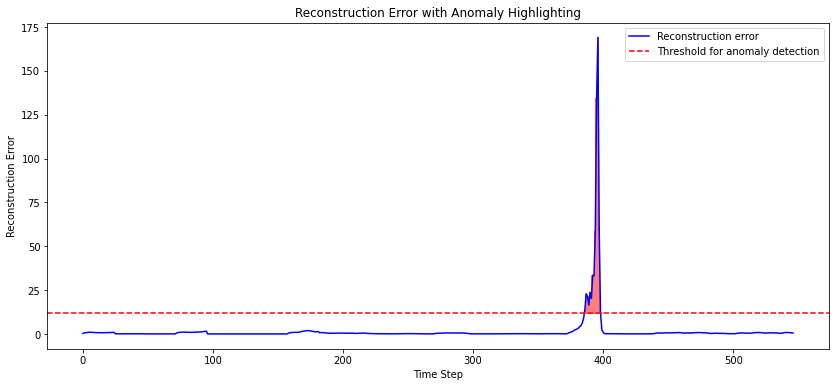

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming reconstruction_errors and threshold are already defined
anomalies = (reconstruction_errors > threshold).flatten()
time_steps = np.arange(len(reconstruction_errors))

plt.figure(figsize=(14, 6))

# Plot the entire reconstruction error line
plt.plot(time_steps, reconstruction_errors, label='Reconstruction error', color='blue')

# Overlay anomalies in red
plt.fill_between(time_steps, reconstruction_errors, threshold, where=anomalies, color='red', step='pre', alpha=0.5)

# Add threshold line
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold for anomaly detection')

plt.title('Reconstruction Error with Anomaly Highlighting')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


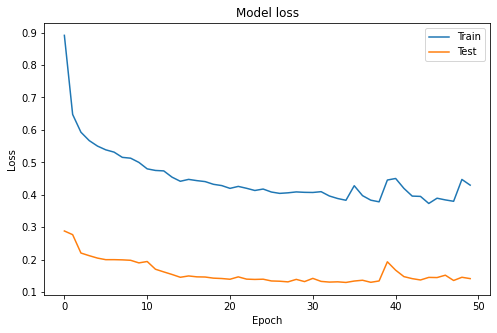

In [29]:
#plot test and train loss vs epoch

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

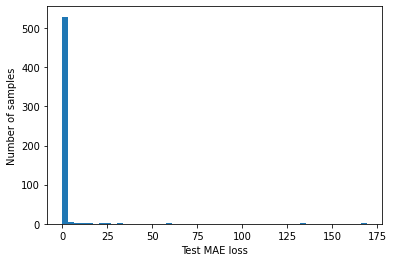

In [30]:
X_test_pred = autoencoder.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [70]:
#inverse transform the reconstruction errors and the threshold
def inverse_transform(reconstruction_errors, threshold,predicted,scaler):
    # Inverse transform the reconstruction errors
    reconstruction_errors_inv = scaler.inverse_transform(reconstruction_errors.reshape(-1, 1)).flatten()
    # Inverse transform the threshold
    threshold_inv = scaler.inverse_transform(np.array([[threshold]]))
    # Inverse transform the predicted values
    predicted_inv = scaler.inverse_transform(predicted.reshape(-1, 1)).flatten()
    return reconstruction_errors_inv, threshold_inv, predicted_inv

In [71]:
reconstruction_errors_inv, threshold_inv,predicted_inv = inverse_transform(reconstruction_errors, threshold,predicted, scaler)

In [72]:
print(reconstruction_errors_inv)
print(threshold_inv)
print(predicted_inv)

[ 430.38594914  442.57599868  446.61747222  450.45518821  455.44693463
  458.16070777  457.31123622  455.21063807  452.94103871  451.03637771
  449.35930604  447.98026112  447.10161508  447.15892184  447.06771827
  446.95472316  447.30489805  447.48776364  447.88873886  448.66435178
  449.89478293  451.29247546  452.44498224  454.57276428  458.39924811
  421.94915948  422.08299106  422.23562756  422.39083768  422.53886064
  422.5824124   422.613186    424.56002073  424.51442419  424.48187241
  424.4166595   424.33760186  424.19859797  424.01999964  423.81140083
  423.56465553  423.30339043  423.05133076  422.82935922  422.65588713
  422.1129779   421.67008723  421.14686819  420.86383743  420.72725875
  420.57768317  420.41878852  420.24045141  420.09615681  419.92933573
  419.5578005   419.0012895   419.19741272  419.42697701  419.67858509
  419.84282927  419.87781993  419.94235818  420.01045235  420.08376401
  420.15589299  420.20120468  420.14794754  420.15175015  420.13199397
  420.

In [83]:
import numpy as np

# Ensuring test_score_df is a separate copy
test_score_df = test.iloc[time_steps].copy()

# Assigning loss if it's an array with the same number of elements as test_score_df
test_score_df['loss'] = reconstruction_errors_inv

# Ensuring threshold_inv is correctly shaped or repeated
# If threshold_inv is a single value or an array with one value meant to be repeated
if threshold_inv.size == 1:
    test_score_df['threshold'] = np.full((len(test_score_df),), threshold_inv.flatten()[0])
else:
    test_score_df['threshold'] = threshold_inv

# Calculating anomaly flags
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

# Assuming 'Volt' exists in the columns and is correctly aligned
test_score_df['Volt'] = test.iloc[time_steps]['Volt']

# Including predicted values, ensure they are aligned in length and indexing with the test_score_df
if len(predicted_inv) == len(test_score_df):
    test_score_df['Predicted_Volt'] = corrected_predicted_values_inv
else:
    print("Warning: Length of predicted values does not match the length of the DataFrame. Check alignment.")

# Print the first few rows to check
print(test_score_df.head())


      Well       Date   Volt        loss   threshold  anomaly
13135  BS3 2022-03-25  329.0  430.385949  887.189707    False
13136  BS3 2022-03-26  343.0  442.575999  887.189707    False
13142  BS3 2022-04-01  401.0  446.617472  887.189707    False
13143  BS3 2022-04-02  401.0  450.455188  887.189707    False
13144  BS3 2022-04-03  400.0  455.446935  887.189707    False


In [66]:
import numpy as np

# Ensuring test_score_df is a separate copy
test_score_df = test.iloc[time_steps].copy()

# Assigning loss if it's an array with the same number of elements as test_score_df
test_score_df['loss'] = reconstruction_errors_inv

# Ensuring threshold_inv is correctly shaped or repeated
# If threshold_inv is a single value or an array with one value meant to be repeated
if threshold_inv.size == 1:
    test_score_df['threshold'] = np.full((len(test_score_df),), threshold_inv.flatten()[0])
else:
    test_score_df['threshold'] = threshold_inv

# Calculating anomaly flags
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']

# Assuming 'Volt' exists in the columns and is correctly aligned
test_score_df['Volt'] = test.iloc[time_steps]['Volt']

# Print the first few rows to check
print(test_score_df.head())


      Well       Date   Volt        loss   threshold  anomaly
13135  BS3 2022-03-25  329.0  430.385949  887.189707    False
13136  BS3 2022-03-26  343.0  442.575999  887.189707    False
13142  BS3 2022-04-01  401.0  446.617472  887.189707    False
13143  BS3 2022-04-02  401.0  450.455188  887.189707    False
13144  BS3 2022-04-03  400.0  455.446935  887.189707    False


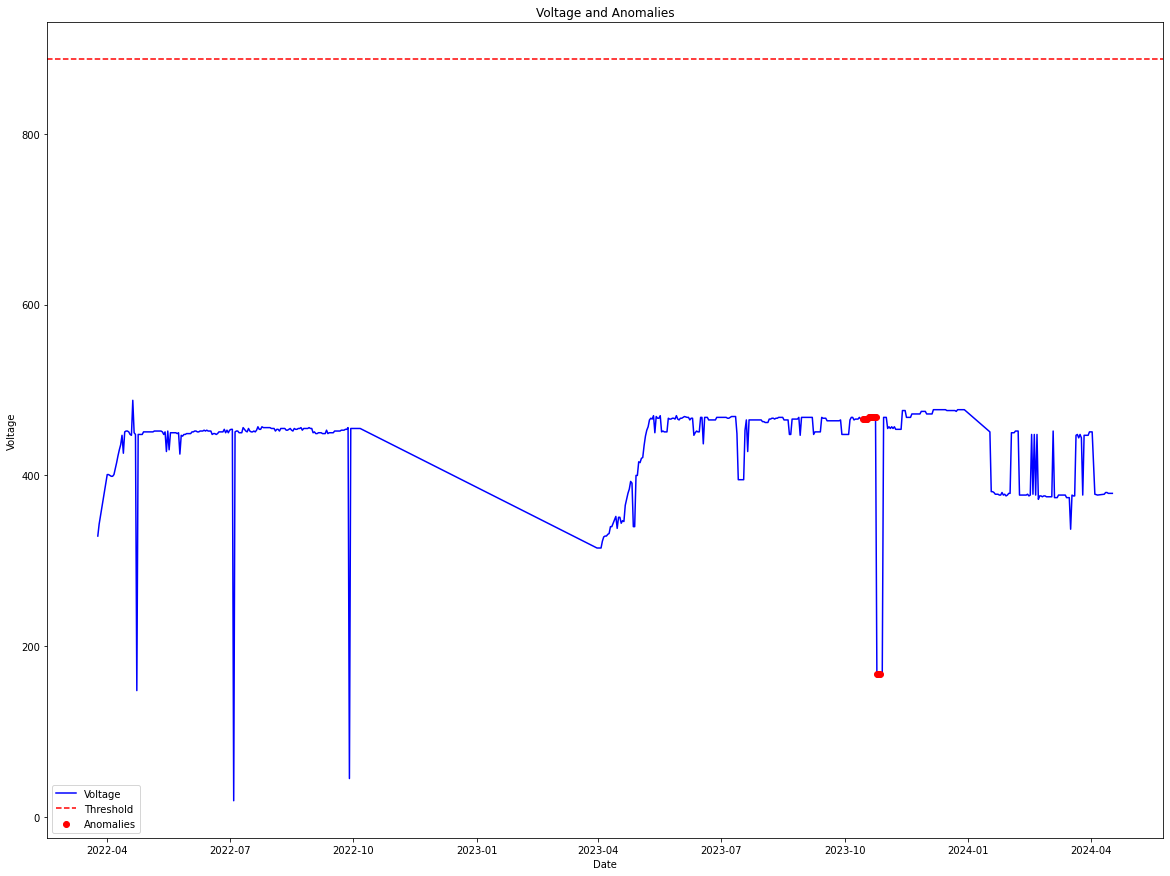

In [68]:
import matplotlib.pyplot as plt

# Create a figure and an axes.
plt.figure(figsize=(20, 15))

# Plotting the voltage.
plt.plot(test_score_df['Date'], test_score_df['Volt'], label='Voltage', color='blue')

# Plotting the threshold (assuming threshold is a constant or has been broadcast to all rows).
plt.axhline(y=test_score_df['threshold'].iloc[0], color='red', linestyle='--', label='Threshold')

# Highlighting anomalies. Filter the rows where 'anomaly' is True and plot those.
anomalies = test_score_df[test_score_df['anomaly']]
plt.scatter(anomalies['Date'], anomalies['Volt'], color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title('Voltage and Anomalies')
plt.xlabel('Date')
plt.ylabel('Voltage')
plt.legend()

# Show the plot
plt.show()


In [69]:
#filter only to print dataframes with anomalies
anomalies = test_score_df[test_score_df['anomaly']]
print(anomalies)

      Well       Date   Volt         loss   threshold  anomaly
13704  BS3 2023-10-15  466.0   974.647497  887.189707     True
13705  BS3 2023-10-16  466.0  1326.239793  887.189707     True
13706  BS3 2023-10-17  466.0  1266.522614  887.189707     True
13707  BS3 2023-10-18  466.0  1072.549094  887.189707     True
13708  BS3 2023-10-19  468.0  1357.591246  887.189707     True
13709  BS3 2023-10-20  468.0  1222.326597  887.189707     True
13710  BS3 2023-10-21  468.0  1744.735447  887.189707     True
13711  BS3 2023-10-22  468.0  1736.399898  887.189707     True
13712  BS3 2023-10-23  468.0  2756.778167  887.189707     True
13713  BS3 2023-10-24  468.0  5755.774258  887.189707     True
13714  BS3 2023-10-25  168.0  7112.915525  887.189707     True
13715  BS3 2023-10-26  168.0  2783.704911  887.189707     True
13716  BS3 2023-10-27  168.0   917.606069  887.189707     True


In [76]:
# Correctly slicing the predicted_values_inv to match the test data starting from time_steps
corrected_predicted_values_inv = predicted_inv[-len(test_score_df):]


In [77]:
# Assigning the corrected predicted values to the DataFrame
test_score_df['Predicted_Volt'] = corrected_predicted_values_inv

# Verifying the lengths match now
print("Adjusted length of predicted values:", len(corrected_predicted_values_inv))
print("Length of DataFrame:", len(test_score_df))


Adjusted length of predicted values: 547
Length of DataFrame: 547


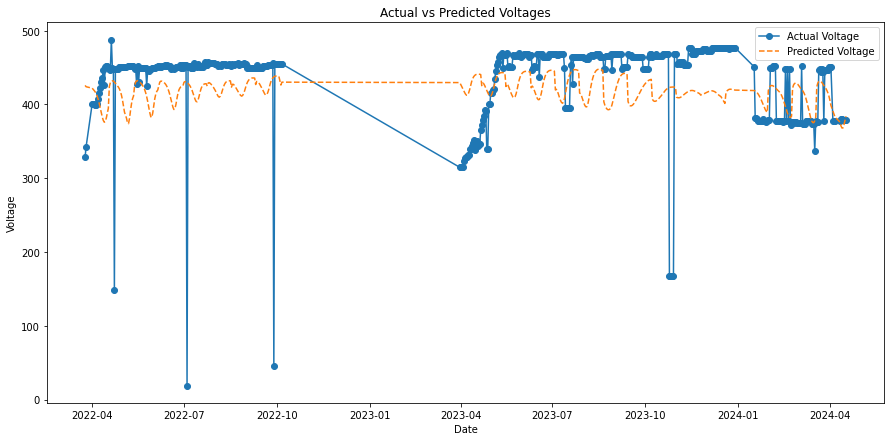

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(test_score_df['Date'], test_score_df['Volt'], label='Actual Voltage', marker='o')
plt.plot(test_score_df['Date'], test_score_df['Predicted_Volt'], label='Predicted Voltage', linestyle='--')
plt.title('Actual vs Predicted Voltages')
plt.xlabel('Date')
plt.ylabel('Voltage')
plt.legend()
plt.show()
